# Imports 

In [4]:
############## to prevent to restart kernel when any changes are made to any imported file ##############
%reload_ext autoreload
%autoreload 2

############## to import any file from some other directory ##############
# sys.path.append("/tmp/fastai/old")

############### to stop printing warnings ##############
import warnings
warnings.filterwarnings('ignore')
def warn(*args, **kwargs):
    pass
warnings.warn = warn
    
import pandas as pd
import numpy as np
import pandas_profiling
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.width', 1000)
############### to increase cells width ##############
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

############### to enable collapsible Headings and Functions ##############
# !pip install jupyter_contrib_nbextensions
# !jupyter contrib nbextension install --user
# !jupyter nbextensions_configurator enable --user
# !jupyter nbextension enable codefolding/main
# search collapsible to enable

############### enable dark theme ##############
# !pip install jupyterthemes
# !jt -t monokai
# !jt -r
# monokai
# solarizedd

############### enable dark theme ##############
from tqdm import tqdm, tqdm_notebook
# use progress_apply to use
tqdm.pandas(tqdm_notebook)

%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import fasttext, string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from geopy.geocoders import Nominatim
from geopy import geocoders
from wordcloud import WordCloud, STOPWORDS
import ast
import folium
from folium import plugins
from allennlp.predictors.predictor import Predictor
import plotly.graph_objs as go
import plotly.offline as py
from geopy.extra.rate_limiter import RateLimiter
from plotly import tools
import seaborn as sns
color = sns.color_palette()
import textstat
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from statistics import *
import concurrent.futures
import time
# import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from collections import defaultdict
from gensim.models import KeyedVectors


# Helper Functions

In [5]:
def plot_readability(a,b,title,bins=0.1,colors=['#3A4750', '#F64E8B']):
    trace1 = ff.create_distplot([a,b], [" Real disaster tweets","Not real disaster tweets"], bin_size=bins, colors=colors, show_rug=False)
    trace1['layout'].update(title=title)
    py.iplot(trace1, filename='Distplot')
    table_data= [["Statistical Measures"," Not real disaster tweets","real disaster tweets"],
                ["Mean",mean(a),mean(b)],
                ["Standard Deviation",pstdev(a),pstdev(b)],
                ["Variance",pvariance(a),pvariance(b)],
                ["Median",median(a),median(b)],
                ["Maximum value",max(a),max(b)],
                ["Minimum value",min(a),min(b)]]
    trace2 = ff.create_table(table_data)
    py.iplot(trace2, filename='Table')

punctuations = string.punctuation
stopwords = list(STOP_WORDS)

parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

import re
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def removeurl(raw_text):
    clean_text = re.sub(r'^https?:\/\/.*[\r\n]*', '', raw_text, flags=re.MULTILINE)
    return clean_text

In [6]:
def save_as_pickle(fname, data):
    with open(fname+'.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

        
def read_pickle(fname):
    with open(fname+'.pickle', 'rb') as handle:
        b = pickle.load(handle)
    return b

# Get Data

In [7]:
PATH="./data/"

In [8]:
train=pd.read_csv(f"{PATH}train.csv")
test=pd.read_csv(f"{PATH}test.csv")

train.shape, test.shape

((7613, 5), (3263, 4))

In [9]:
train.head()

id keyword location                                                                                                                                   text  target
0   1     NaN      NaN                                                                  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all       1
1   4     NaN      NaN                                                                                                 Forest fire near La Ronge Sask. Canada       1
2   5     NaN      NaN  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected       1
3   6     NaN      NaN                                                                      13,000 people receive #wildfires evacuation orders in California        1
4   7     NaN      NaN                                               Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school        1

In [10]:
df=train.copy()
df.fillna("missing", inplace=True)
df.shape

(7613, 5)

In [11]:
df["location"]=df.location.str.lower().str.strip()

# EDA

## Profiling & Stats

In [10]:
profile = df.profile_report(title='Pandas Profiling Report',style={'full_width':True})
profile.to_file(output_file=f"{PATH}train_profile.html")
profile

In [11]:
df[["text", "target"]].head(20)

text  target
0                                                                   Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all       1
1                                                                                                  Forest fire near La Ronge Sask. Canada       1
2   All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected       1
3                                                                       13,000 people receive #wildfires evacuation orders in California        1
4                                                Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school        1
5                          #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires       1
6                                         #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas       1
7                                                                             I'm on top of the hill and I can see a fire in the woods...       1
8                                                         There's an emergency evacuation happening now in the building across the street       1
9                                                                                    I'm afraid that the tornado is coming to our area...       1
10                                                                                            Three people died from the heat wave so far       1
11      Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding       1
12                                                           #raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count        1
13                                                                                                #Flood in Bago Myanmar #We arrived Bago       1
14                                                                               Damage to school bus on 80 in multi car crash #BREAKING        1
15                                                                                                                         What's up man?       0
16                                                                                                                          I love fruits       0
17                                                                                                                       Summer is lovely       0
18                                                                                                                      My car is so fast       0
19                                                                                                           What a goooooooaaaaaal!!!!!!       0

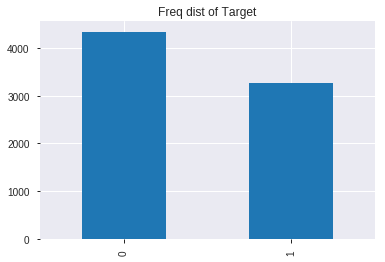

In [12]:
df['target'].value_counts().plot.bar(title='Freq dist of Target')

In [13]:
cnt_srs = df['target'].value_counts()
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Jet',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

## target distribution ##
labels = (np.array(cnt_srs.index))
sizes = (np.array((cnt_srs / cnt_srs.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

## Location Distribution

In [14]:
cnt_ = train['location'].value_counts()
cnt_.reset_index()
cnt_ = cnt_[:20,]
trace1 = go.Bar(
                x = cnt_.index,
                y = cnt_.values,
                name = "Number of tweets in dataset according to location",
                marker = dict(color = 'rgba(200, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )

data = [trace1]
layout = go.Layout(barmode = "group",title = 'Number of tweets in dataset according to location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

## Tweets Per Class

In [15]:
train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]
cnt_1 = train1_df['location'].value_counts()
cnt_1.reset_index()
cnt_1 = cnt_1[:20,]

cnt_0 = train0_df['location'].value_counts()
cnt_0.reset_index()
cnt_0 = cnt_0[:20,]

trace1 = go.Bar(
                x = cnt_1.index,
                y = cnt_1.values,
                name = "Number of tweets about real disaster location wise",
                marker = dict(color = 'rgba(255, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )
trace0 = go.Bar(
                x = cnt_0.index,
                y = cnt_0.values,
                name = "Number of tweets other than real disaster location wise",
                marker = dict(color = 'rgba(79, 82, 97, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )


data = [trace0,trace1]
layout = go.Layout(barmode = 'stack',title = 'Number of tweets in dataset according to location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

## Comparison of Text Lengths

In [16]:
train['length'] = train['text'].apply(len)
data = [
    go.Box(
        y=train[train['target']==0]['length'],
        name='Fake'
    ),
    go.Box(
        y=train[train['target']==1]['length'],
        name='Real'
    )
]
layout = go.Layout(
    title = 'Comparison of text length in Tweets'
)
fig = go.Figure(data=data, layout=layout)
fig.show()

## Word CLoud

In [17]:
st_words = set(STOPWORDS)
st_words.update(['https','CO','RT','Please','via','amp','place','new','ttot','best','great','top','ht','ysecrettravel','ysecrettravel_'])

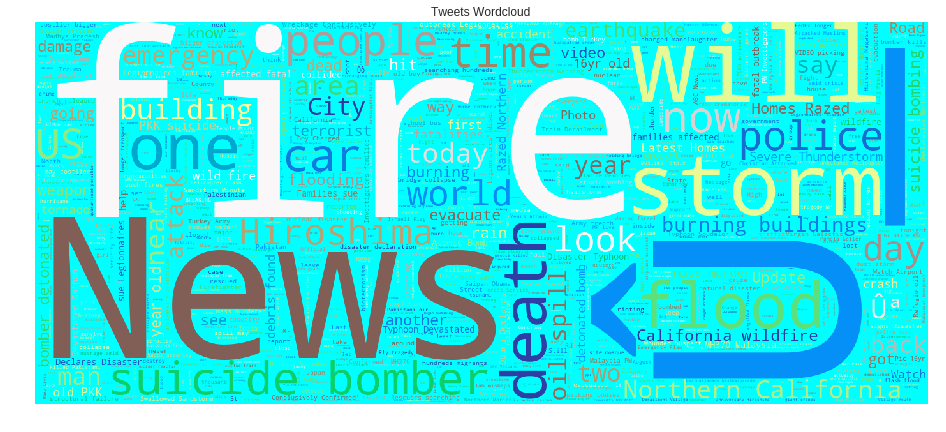

In [18]:
wc = WordCloud(height=600,repeat=False,width=1400,max_words=1000,stopwords=st_words,colormap='terrain',background_color='Cyan',mode='RGBA').generate(' '.join(df[df["target"]==1]['text'].dropna().astype(str)))
plt.figure(figsize = (16,16))
plt.imshow(wc)
plt.title('Tweets Wordcloud')
plt.axis('off')
plt.show()

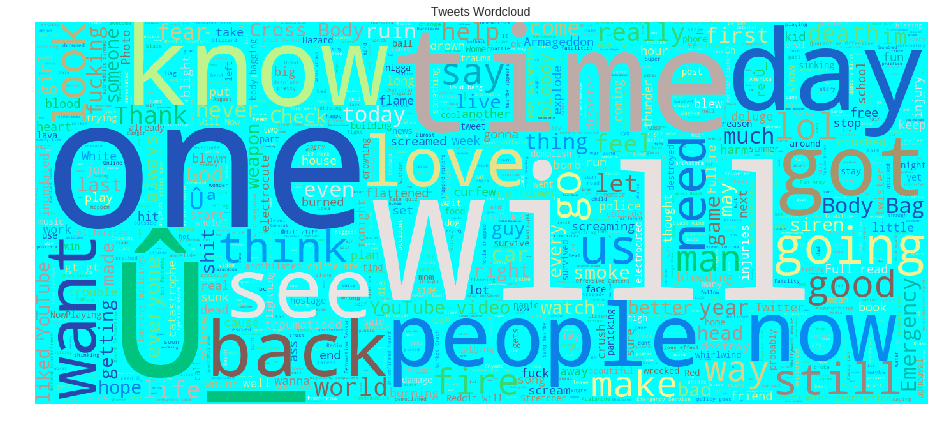

In [19]:
wc = WordCloud(height=600,repeat=False,width=1400,max_words=1000,stopwords=st_words,colormap='terrain',background_color='Cyan',mode='RGBA').generate(' '.join(df[df["target"]==0]['text'].dropna().astype(str)))
plt.figure(figsize = (16,16))
plt.imshow(wc)
plt.title('Tweets Wordcloud')
plt.axis('off')
plt.show()

In [20]:
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [38]:
df.location.value_counts().head(20)

missing            2533
usa                 105
new york             77
united states        50
london               50
nigeria              35
canada               34
worldwide            31
uk                   30
india                28
los angeles, ca      28
mumbai               24
california           21
washington, dc       21
kenya                21
everywhere           20
chicago, il          20
australia            19
new york, ny         17
los angeles          16
Name: location, dtype: int64

In [39]:
g=pd.DataFrame(df.groupby(["location", "target"]).size()).sort_values([0], ascending=False)
g.head(10)

0
location      target      
missing       0       1458
              1       1075
usa           1         67
new york      0         59
usa           0         38
london        0         33
nigeria       1         28
united states 1         27
              0         23
india         1         22

## Visualizing Count Vector Data

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
# count_vectorizer = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}', ngram_range=(1, 3), stop_words = 'english')

# Call the fit() function in order to learn a vocabulary from one or more documents.
count_vectorizer.fit(train.text)

# Call the transform() function on one or more documents as needed to encode each as a vector.
X_train_count_vec = count_vectorizer.transform(train.text)
X_test_count_vec = count_vectorizer.transform(test.text)

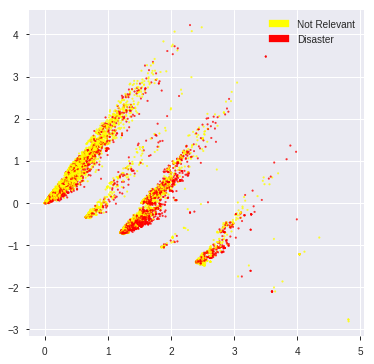

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib

truncated_svd_cv = TruncatedSVD(n_components=2)
truncated_svd_scores = truncated_svd_cv.fit_transform(X_train_count_vec)

fig = plt.figure(figsize=(6, 6))   
colors = ['yellow','red']

plt.scatter(truncated_svd_scores[:,0], truncated_svd_scores[:,1] ,s = 3, alpha=.8, c=train.target, cmap=matplotlib.colors.ListedColormap(colors))

ir_patch = mpatches.Patch(color='yellow',label='Not Relevant')

dis_patch = mpatches.Patch(color='red',label='Disaster')

plt.legend(handles=[ir_patch, dis_patch], prop={'size': 10})

plt.show()

In [25]:
X_train_count_vec[:5]

<5x21637 sparse matrix of type '<class 'numpy.int64'>'
	with 61 stored elements in Compressed Sparse Row format>

## Visualiza TDIDF Data

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vectorizer = TfidfVectorizer(min_df=3,  max_features=None, strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}', ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1, stop_words = 'english')
tfidf_vectorizer = TfidfVectorizer()

tfidf_vectorizer.fit(train.text)
X_train_tfidf = tfidf_vectorizer.transform(train.text)
X_test_tfidf = tfidf_vectorizer.transform(test.text)

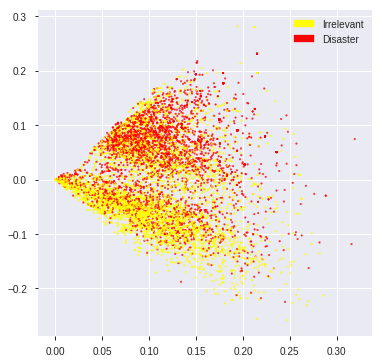

In [27]:
truncated_svd_tfidf = TruncatedSVD(n_components=2)
truncated_svd_tfidf.fit(X_train_tfidf)
truncated_svd_tfidf_scores = truncated_svd_tfidf.transform(X_train_tfidf)

fig = plt.figure(figsize=(6, 6))   
colors = ['yellow','red']

plt.scatter(truncated_svd_tfidf_scores[:,0], truncated_svd_tfidf_scores[:,1],s = 3, alpha=.8, c=train.target, cmap=matplotlib.colors.ListedColormap(colors))

ir_patch = mpatches.Patch(color='yellow',label='Irrelevant')

dis_patch = mpatches.Patch(color='red',label='Disaster')

plt.legend(handles=[ir_patch, dis_patch], prop={'size': 10})

plt.show()

## Visualize GloVe Vectors

In [28]:
# ! wget wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-PK,en-US;q=0.9,en;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-data-sets/8542/11957/compressed/glove.6B.50d.txt.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1578661446&Signature=YBF%2BWdBKHfv%2FSgVnAqtVHAT4qLRiOu%2FfYM7Th7Vha4DIfrWJIbdKgGBSN1q%2FW7RgZqQBOhp5GOGe5L%2BzsV5odoQq7UqB0Zxbw0cVR%2FdVQlgxNQKaZJXDiixPbAYne0fGiuEEcmCMmH190ETodB%2B%2BgLO0I3pZQfQpMvB%2BCVYJB0HSTiCj53Fr0yCpl8A%2FUggUe2LB7%2FQyZrxfLHnIFvVg0je2Hb%2FI6FfADqUnQJv%2FPjv%2FKS178Z384yB643NOZmCDGli7ev8u8Z4bEQaCVKT4QzNOix1RP6dpZZpRll9BLV40%2FuiyJjReu9YoNg1%2BVsTZgXKx7FN4hME5JWM3ZoEp2Q%3D%3D&response-content-disposition=attachment%3B+filename%3Dglove.6B.50d.txt.zip" -O "glove.6B.50d.txt.zip" -c


In [29]:
# !ls ../input/glove-global-vectors-for-word-representation
import os
glove_dir = f'{PATH}/' # This is the folder with the dataset

glove_embedding = {} # We create a dictionary of word -> embedding
# f = open(os.path.join(glove_dir, 'glove.6B.50d.txt')) # Open file
f = open(f'{PATH}glove.6B.50d.txt') # Open file

# In the dataset, each line represents a new word embedding
# The line starts with the word and the embedding values follow
count=0
try:
    for line in f:
        values = line.split()
        word = values[0] # The first value is the word, the rest are the values of the embedding
        embedding = np.asarray(values[1:], dtype='float32') # Load embedding
        glove_embedding[word] = embedding # Add embedding to our embedding dictionary
except:
    count=count+1
f.close()

print('Found %s word vectors.' % len(glove_embedding), count)


Found 209 word vectors. 1


In [30]:
from nltk.tokenize import RegexpTokenizer

def tokenizeText(df, text_column):
    tokenizer = RegexpTokenizer(r'\w+')
    df["tokens"] = df[text_column].apply(tokenizer.tokenize)
    return df

train = tokenizeText(train, "text")
train.head(2)

id keyword location                                                                   text  target  length                                                                              tokens
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all       1      69  [Our, Deeds, are, the, Reason, of, this, earthquake, May, ALLAH, Forgive, us, all]
1   4     NaN      NaN                                 Forest fire near La Ronge Sask. Canada       1      38                                       [Forest, fire, near, La, Ronge, Sask, Canada]

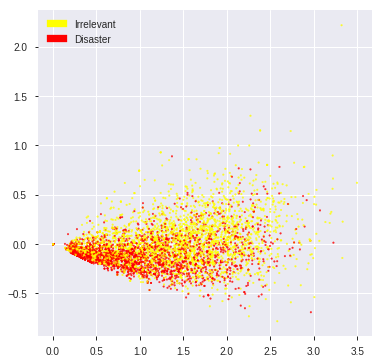

In [31]:
# print(glove_embedding)
all_embs = np.stack(glove_embedding.values())
emb_mean = all_embs.mean() # Calculate mean
emb_std = all_embs.std() # Calculate standard deviation
emb_mean,emb_std
# For every dimention(eg. 1 to 50), get the average of every word's dimention in the sentence.
def get_average_word2vec(tokens_list, pretrained_word_vector, generate_missing=False, num_dims = 50):
    if len(tokens_list)<1:
        return np.zeros(num_dims)
    if generate_missing:
        vectorized = [pretrained_word_vector[word] if word in pretrained_word_vector else np.random.rand(num_dims) for word in tokens_list]
    else:
        vectorized = [pretrained_word_vector[word] if word in pretrained_word_vector else np.zeros(num_dims) for word in tokens_list]
#        print(np.array(vectorized).shape)
    length = len(vectorized)
#    print(length)
    summed = np.sum(vectorized, axis=0)
#    print(np.array(summed).shape)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(pretrained_word_vector, df, token_column, generate_missing=False):
    embeddings = df[token_column].apply(lambda x: get_average_word2vec(x, pretrained_word_vector, generate_missing=generate_missing))
    return list(embeddings)

embeddings = get_word2vec_embeddings(glove_embedding, train, "tokens")
np.array(embeddings).shape
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(embeddings, train['target'], test_size=0.2, random_state=40)
X_train_glove = np.array(X_train_glove)
truncated_svd_glove = TruncatedSVD(n_components=2)
truncated_svd_glove.fit(X_train_glove)
truncated_svd_glove_scores = truncated_svd_glove.transform(X_train_glove)

fig = plt.figure(figsize=(6, 6))   
colors = ['yellow','red']

plt.scatter(truncated_svd_glove_scores[:,0], truncated_svd_glove_scores[:,1],s = 3, alpha=.8, c=y_train_glove, cmap=matplotlib.colors.ListedColormap(colors))

ir_patch = mpatches.Patch(color='yellow',label='Irrelevant')

dis_patch = mpatches.Patch(color='red',label='Disaster')

plt.legend(handles=[ir_patch, dis_patch], prop={'size': 10})

plt.show()


## Check GloVe Embeddings Coverage

In [32]:
# ! wget wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-PK,en-US;q=0.9,en;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-data-sets/14154/19053/compressed/crawl-300d-2M.vec.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1578667588&Signature=pgcykdbRRPVFb%2FWny%2FebEcEFeuzl5gZMlOigrbB%2FJ7Ei9F%2FrIh4xoEOl2EPzjcpk4x2QPCnQO4z%2BHhx20wDxXZs5cD5w6RFOFX14q9rGM0ZPqlCRgHCQGzZ9dkquZROHan7Y%2FpmDMZg%2BJw3i7HouyLTkoyzR8PCYg%2Bk3x5m3KoM5np3Vm9NXGQGasK45lDp%2FTiHMkOcdCs7ZIPM4%2BUILkWiAyrU5rHqHwCjzL9Y9C92VZNxkan99mmQmIQ1v8anF89Ad1nX1Fbzwjh2OEr6Jn0ReQKb0ElH4gSaWtJNT3SIWzD8MCRZmGMZ79pcJKToY7iIbXhQR9VqVGGD6DRVkQA%3D%3D&response-content-disposition=attachment%3B+filename%3Dcrawl-300d-2M.vec.zip" -O "crawl-300d-2M.vec.zip" -c



In [33]:
def build_vocab(tweets):
    vocab = {}        
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

train_tweets = train['text'].apply(lambda s: s.split()).values
train_vocab = build_vocab(train_tweets)
test_tweets = test['text'].apply(lambda s: s.split()).values
test_vocab = build_vocab(test_tweets)

# GloVe-300d-840B
# FastText-Crawl-300d-2M 
embeddings_glove = np.load(f'{PATH}glove.840B.300d.pkl', allow_pickle=True)
# embeddings_fasttext = KeyedVectors.load_word2vec_format(f'{PATH}crawl-300d-2M.vec')

# Words in intersection of vocab and embeddings are stored in covered along with their counts. Words in vocab that don't exist in embeddings are stored in oov along with their counts. n_covered and n_oov are total number of counts and they are used for calculating coverage percentages.

# Both GloVe and FastText embeddings have more than 50% vocab and 80% text coverage without cleaning. GloVe and FastText coverage are very close but GloVe has slightly higher coverage.

def check_coverage(vocab, embeddings, embeddings_name, dataset_name):
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    print('{} Embeddings cover {:.2%} of {} vocab'.format(embeddings_name, vocab_coverage, dataset_name))
    print('{} Embeddings cover {:.2%} of {} text'.format(embeddings_name, text_coverage, dataset_name))

#     sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
#     return sorted_oov
    return oov

train_oov_glove = check_coverage(train_vocab, embeddings_glove, 'GloVe', 'Training')
test_oov_glove = check_coverage(test_vocab, embeddings_glove, 'GloVe', 'Test')
# train_oov_fasttext = check_coverage(train_vocab, embeddings_fasttext, 'FastText', 'Training')
# test_oov_fasttext = check_coverage(test_vocab, embeddings_fasttext, 'FastText', 'Test')

print("""GloVe Embeddings cover 52.06% of Training vocab
GloVe Embeddings cover 82.68% of Training text
GloVe Embeddings cover 57.21% of Test vocab
GloVe Embeddings cover 81.85% of Test text""")

GloVe Embeddings cover 52.06% of Training vocab
GloVe Embeddings cover 82.68% of Training text
GloVe Embeddings cover 57.21% of Test vocab
GloVe Embeddings cover 81.85% of Test text
GloVe Embeddings cover 52.06% of Training vocab
GloVe Embeddings cover 82.68% of Training text
GloVe Embeddings cover 57.21% of Test vocab
GloVe Embeddings cover 81.85% of Test text


## Get Country

In [66]:
location_grp=pd.DataFrame(df.groupby(["location"]).size()).reset_index(drop=False)
top_vals=location_grp[location_grp[0]>2].location.tolist()
top_vals[:5]

['#flightcity uk', '21.462446,-158.022017', '304', '?', '??']

In [67]:
count=0
geolocator= Nominatim(user_agent="myGeocoder")
def get_country(addr):
    global count
    print(count, end="\r")
    count=count+1
    try:
        loc = geolocator.geocode(addr)
        country=loc.address.split(",")[-1].strip()
        return country
    except Exception as e:
#         print(e)
        return "missing"

In [68]:
# cntrs=[get_country(x) for x in top_vals]
# country_map=dict(zip(top_vals, cntrs))

# save_as_pickle("country_map", country_map)
country_map=read_pickle(f"{PATH}country_map")

In [69]:
# country_map.pop('missing', None)

In [70]:
# df["country"]=df[df.location.isin(top_vals)].location.apply(get_country)

df["country"]=df.location.copy()
df=df.replace({"country": country_map})

In [71]:
g=pd.DataFrame(df.groupby(["country", "target"]).size()).sort_values([0], ascending=False)
g.head(10)

0
country                  target      
missing                  0       1673
                         1       1252
United States of America 0        409
                         1        281
United States            1        185
                         0        132
United Kingdom           0        123
                         1         74
Canada                   1         59
                         0         52

## Get Lat,Long

In [72]:
count=0
geolocator= Nominatim(user_agent="myGeocoder")
def get_lat_long(addr):
    global count
    print(count, end="\r")
    count=count+1
    try:
        loc = geolocator.geocode(addr)
        lat, long=loc.raw["lat"], loc.raw["lon"]
        return [lat, long]
    except Exception as e:
#         print(e)
        return [0,0]

In [73]:
# loct=[get_lat_long(x) for x in top_vals]
# loct_map=dict(zip(top_vals, loct))

# save_as_pickle("loct_map", loct_map)
loct_map=read_pickle(f"{PATH}loct_map")

In [74]:
pd.DataFrame(loct_map).T.head()

0             1
missing   53.0361586    -2.9796483
usa       39.7837304  -100.4458825
new york  40.7127281   -74.0060152
london    51.5073219    -0.1276474
nigeria    9.6000359     7.9999721

In [75]:
loct_map_ = {k: str(v) for k,v in loct_map.items()}

df["point"]=df[df["location"].isin(top_vals)]["location"].copy()
df=df.replace({"point": loct_map_})

df.head(2)

id  keyword location                                                                  text target                                                                                                          sentiment_result sentiment                                                                                                       sentiment_result_kw sentiment_kw  country                         point         lat        long
0   1  missing  missing  our deeds are the reason of this earthquake may allah forgive us all      1  {'logits': [2.5725619792938232, -2.4990909099578857], 'probs': [0.9937670230865479, 0.006232950836420059], 'label': '1'}  positive  {'logits': [-4.675931930541992, 4.7121734619140625], 'probs': [8.370690193260089e-05, 0.9999163150787354], 'label': '0'}     positive  missing  ['53.0361586', '-2.9796483']  53.0361586  -2.9796483
1   4  missing  missing                                 forest fire near la ronge sask canada      1   {'logits': [1.2039726972579956, -1.1096571683883667], 'probs': [0.9099995493888855, 0.09000041335821152], 'label': '1'}  positive  {'logits': [-4.675931930541992, 4.7121734619140625], 'probs': [8.370690193260089e-05, 0.9999163150787354], 'label': '0'}     positive  missing  ['53.0361586', '-2.9796483']  53.0361586  -2.9796483

In [76]:
df["point"].fillna("[0,0]", inplace=True)
df["point"]=df.point.apply(lambda s: list(ast.literal_eval(s)))
df[df["point"]!="missing"].head(2)

id  keyword location                                                                  text target                                                                                                          sentiment_result sentiment                                                                                                       sentiment_result_kw sentiment_kw  country                     point         lat        long
0   1  missing  missing  our deeds are the reason of this earthquake may allah forgive us all      1  {'logits': [2.5725619792938232, -2.4990909099578857], 'probs': [0.9937670230865479, 0.006232950836420059], 'label': '1'}  positive  {'logits': [-4.675931930541992, 4.7121734619140625], 'probs': [8.370690193260089e-05, 0.9999163150787354], 'label': '0'}     positive  missing  [53.0361586, -2.9796483]  53.0361586  -2.9796483
1   4  missing  missing                                 forest fire near la ronge sask canada      1   {'logits': [1.2039726972579956, -1.1096571683883667], 'probs': [0.9099995493888855, 0.09000041335821152], 'label': '1'}  positive  {'logits': [-4.675931930541992, 4.7121734619140625], 'probs': [8.370690193260089e-05, 0.9999163150787354], 'label': '0'}     positive  missing  [53.0361586, -2.9796483]  53.0361586  -2.9796483

In [63]:
df[['lat','long']] = pd.DataFrame(df.point.values.tolist(), index= df.index)
df.head(2)

id  keyword location                                                                  text target                                                                                                          sentiment_result sentiment                                                                                                       sentiment_result_kw sentiment_kw  country                     point         lat        long
0   1  missing  missing  our deeds are the reason of this earthquake may allah forgive us all      1  {'logits': [2.5725619792938232, -2.4990909099578857], 'probs': [0.9937670230865479, 0.006232950836420059], 'label': '1'}  positive  {'logits': [-4.675931930541992, 4.7121734619140625], 'probs': [8.370690193260089e-05, 0.9999163150787354], 'label': '0'}     positive  missing  [53.0361586, -2.9796483]  53.0361586  -2.9796483
1   4  missing  missing                                 forest fire near la ronge sask canada      1   {'logits': [1.2039726972579956, -1.1096571683883667], 'probs': [0.9099995493888855, 0.09000041335821152], 'label': '1'}  positive  {'logits': [-4.675931930541992, 4.7121734619140625], 'probs': [8.370690193260089e-05, 0.9999163150787354], 'label': '0'}     positive  missing  [53.0361586, -2.9796483]  53.0361586  -2.9796483

## Map Plots

In [61]:
location=df.groupby(['lat','long','location']).size().reset_index(name='count').sort_values(by='count',ascending=False)
location=location[location['count']>5]
location.head()

lat          long       location  count
3142  53.0361586    -2.9796483        missing   2533
3065  39.7837304  -100.4458825            usa    105
3078  40.7127281   -74.0060152       new york     77
3064  39.7837304  -100.4458825  united states     50
3132  51.5073219    -0.1276474         london     50

In [62]:
location['color']=location['count'].apply(lambda count:"Black" if count>=400 else
                                         "green" if count>=300 and count<400 else
                                         "Orange" if count>=200 and count<300 else
                                         "darkblue" if count>=150 and count<200 else
                                         "red" if count>=100 and count<150 else
                                         "lightblue" if count>=75 and count<100 else
                                         "brown" if count>=50 and count<75 else
                                         "grey")
location['size']=location['count'].apply(lambda count:12 if count>=400 else
                                         10 if count>=300 and count<400 else
                                         8 if count>=200 and count<300 else
                                         6 if count>=150 and count<200 else
                                         4 if count>=100 and count<150 else
                                         2 if count>=75 and count<100 else
                                         1 if count>=50 and count<75 else
                                         0.1)
location.head()

lat          long       location  count      color  size
3142  53.0361586    -2.9796483        missing   2533      Black  12.0
3065  39.7837304  -100.4458825            usa    105        red   4.0
3078  40.7127281   -74.0060152       new york     77  lightblue   2.0
3064  39.7837304  -100.4458825  united states     50      brown   1.0
3132  51.5073219    -0.1276474         london     50      brown   1.0

In [48]:
# location["size"]=location["size"]*50
# location.head()

In [49]:

m=folium.Map([34.2012,-118.4662],zoom_start=11)
#location=location[0:2000]
for lat,lon,area,color,count,size in zip(location['lat'],location['long'],location['location'],location['color'],location['count'],location['size']):
     folium.CircleMarker([lat, lon],
                            popup=area,
                            radius=size,
                            color='b',
                            fill=True,
                            fill_opacity=0.7,
                            fill_color=color,
                           ).add_to(m)
m.save(f'{PATH}tweets.html')

In [50]:
location1=location[0:100]
location_data = location[['lat', 'long']].as_matrix()

# plot heatmap
m.add_children(plugins.HeatMap(location_data, radius=15))
# m.save(f'{PATH}heatmap.html')
m

In [51]:
df = train['location'].value_counts()[:20,]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['location', 'counts'] 
geolocator = Nominatim(user_agent="specify_your_app_name_here")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
dictt_latitude = {}
dictt_longitude = {}
for i in df['location'].values:
    print(i)
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude
df['latitude']= df['location'].map(dictt_latitude)
df['longitude'] = df['location'].map(dictt_longitude)

USA
New York
United States
London
Canada
Nigeria
UK
Los Angeles, CA
India
Mumbai
Washington, DC
Kenya
Worldwide
Australia
Chicago, IL
California
Everywhere
California, USA
New York, NY
United Kingdom


In [52]:
map1 = folium.Map(location=[10.0, 10.0], tiles='CartoDB dark_matter', zoom_start=2.3)
markers = []
for i, row in df.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)
map1

## Word Frequency

In [53]:
from collections import defaultdict
train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'red')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words if tweet is not real disaster", 
                                          "Frequent words if tweet is real disaster"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

## Top keywords

In [54]:
train.keyword.value_counts()[:20].iplot(kind='bar', title='Top 20 keywords in text', color='red')


## Bigram Plots

In [55]:
def get_bgs(mydf):
#     freq_dict=DefaultDict()
    freq_dict = defaultdict(int)

    for sent in mydf["text"]:
        for word in generate_ngrams(sent,2):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    fd_sorted.columns = ["word", "wordcount"]
    trace0 = horizontal_bar_chart(fd_sorted.head(50), 'red')
    return trace0


train0_df=train[train.target==0]
train1_df=train[train.target==1]
trace0=get_bgs(train0_df)
trace1=get_bgs(train1_df)


# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent words if tweet is not real disaster", 
                                          "Frequent words if tweet is real disaster"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

## Trigram Plots

In [56]:
def get_bgs(mydf):
#     freq_dict=DefaultDict()
    freq_dict = defaultdict(int)

    for sent in mydf["text"]:
        for word in generate_ngrams(sent,3):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    fd_sorted.columns = ["word", "wordcount"]
    trace0 = horizontal_bar_chart(fd_sorted.head(50), 'red')
    return trace0


train0_df=train[train.target==0]
train1_df=train[train.target==1]
trace0=get_bgs(train0_df)
trace1=get_bgs(train1_df)


# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent words if tweet is not real disaster", 
                                          "Frequent words if tweet is real disaster"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

## Spell Corrector

In [58]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

train["text_corr"]=train.text.apply(lambda x: correct_spellings(x))

# text = "corect me plese caaaar"
# correct_spellings(text)
# df['text']=df['text'].apply(lambda x : correct_spellings(x)#)


In [59]:
train.to_pickle(f"{PATH}train_spellcorrected.pickle")
train=pd.read_pickle(f"{PATH}train_spellcorrected.pickle")


## Creating Meta Featurs

In [60]:
# Number of words in the text
# Number of unique words in the text
# Number of characters in the text
# Number of stopwords
# Number of punctuations
# Number of upper case words
# Number of title case words
# Average length of the words
train["num_words"] = train["text"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train["num_unique_words"] = train["text"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train["num_chars"] = train["text"].apply(lambda x: len(str(x)))
test["num_chars"] = test["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train["num_stopwords"] = train["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test["num_stopwords"] = test["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
train["num_punctuations"] =train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_punctuations"] =test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train["num_words_upper"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train["num_words_title"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train["mean_word_len"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

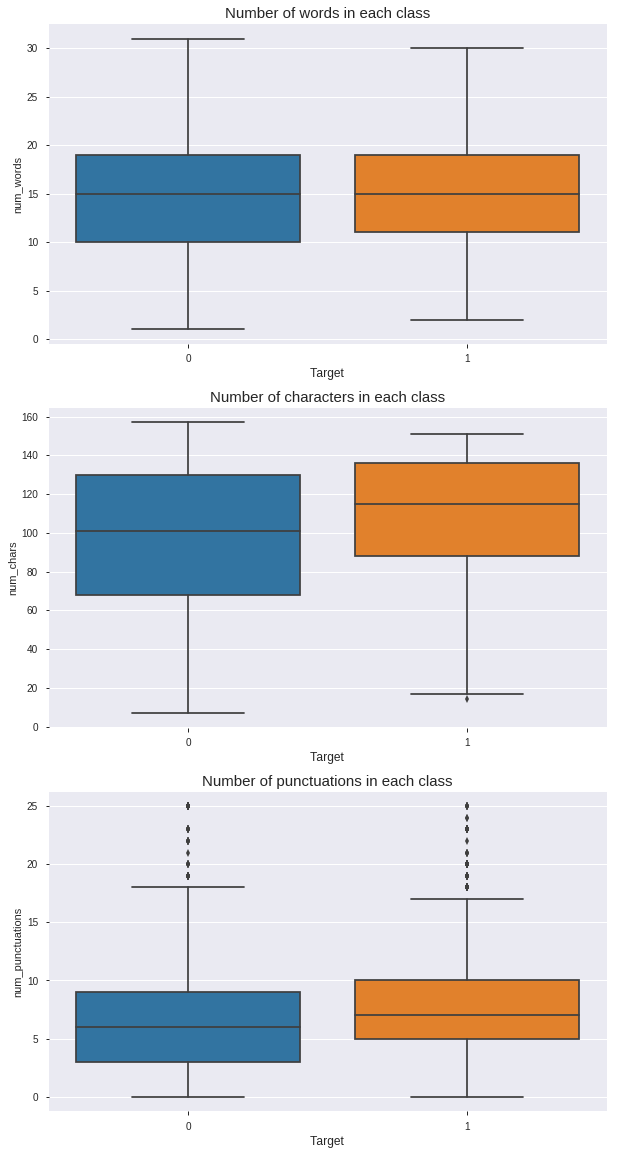

In [61]:
# Plotting of meta features vs each target class (0 or 1)
train['num_words'].loc[train['num_words']>60] = 100 #truncation for better visuals
train['num_punctuations'].loc[train['num_punctuations']>25] = 25 #truncation for better visuals
train['num_chars'].loc[train['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='target', y='num_words', data=train, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='target', y='num_chars', data=train, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='target', y='num_punctuations', data=train, ax=axes[2])
axes[2].set_xlabel('Target', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

## Histogram plots

### 8.1 Histogram Plots of number of words per each class (0 or 1)¶


In [62]:
train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]

fig = go.Figure()
fig.add_trace(go.Histogram(x=train1_df['num_words'],name = 'Number of words in tweets about real disaster'))
fig.add_trace(go.Histogram(x=train0_df['num_words'],name = 'Number of words in tweets other than real disaster'))

# Overlay both histograms
fig.update_layout(barmode='stack')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

### 8.2 Histogram Plots of number of characters per each class (0 or 1)¶


In [63]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train1_df['num_chars'],name = 'Number of chars in tweets about real disaster',marker = dict(color = 'rgba(200, 100, 0, 0.8)')))
fig.add_trace(go.Histogram(x=train0_df['num_chars'],name = 'Number of chars in tweets about real disaster',marker = dict(color = 'rgba(25, 133, 120, 0.8)')))

# Overlay both histograms
fig.update_layout(barmode='stack')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

### 8.3 Histogram Plots of number of punctuations per each class (0 or 1)¶


In [64]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train1_df['num_punctuations'],name = 'Number of punctuations in tweets about real disaster',marker = dict(color = 'rgba(97, 175, 222, 0.8)')))
fig.add_trace(go.Histogram(x=train0_df['num_punctuations'],name = 'Number of punctuations in tweets other than real disaster',marker = dict(color = 'rgba(200, 10, 150, 0.8)')))

# Overlay both histograms
fig.update_layout(barmode='stack')
# Reduce opacity to see both histograms
fig.update_traces(opacity=1)
fig.show()

### 8.4 Histogram plots of number of words in train and test sets¶


In [65]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train['num_words'],name = 'Number of words in training tweets',marker = dict(color = 'rgba(255, 0, 0, 0.8)')))
fig.add_trace(go.Histogram(x=test['num_words'],name = 'Number of words in testing tweets ',marker = dict(color = 'rgba(0, 187, 187, 0.8)')))

# Overlay both histograms
fig.update_layout(barmode='stack')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

### 8.5 Histogram plots of number of chars in train and test sets¶


In [66]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train['num_chars'],name = 'Number of chars in training tweets',marker = dict(color = 'rgba(25, 13, 8, 0.8)')))
fig.add_trace(go.Histogram(x=test['num_chars'],name = 'Number of chars in testing tweets ',marker = dict(color = 'rgba(8, 25, 187, 0.8)')))

# Overlay both histograms
fig.update_layout(barmode='stack')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

### 8.6 Histogram plots of number of punctuations in train and test sets¶


In [67]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train['num_punctuations'],name = 'Number of punctuations in training tweets',marker = dict(color = 'rgba(222, 111, 33, 0.8)')))
fig.add_trace(go.Histogram(x=test['num_punctuations'],name = 'Number of punctuations in testing tweets ',marker = dict(color = 'rgba(33, 111, 222, 0.8)')))

# Overlay both histograms
fig.update_layout(barmode='stack')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

## Readability features


Readability is the ease with which a reader can understand a written text. In natural language processing, the readability of text depends on its content. It focuses on the words we choose, and how we put them into sentences and paragraphs for the readers to comprehend.
9.1 The Flesch Reading Ease formula
In the Flesch reading-ease test, higher scores indicate material that is easier to read; lower numbers mark passages that are more difficult to read. 





### 9.1 The Flesch Reading Ease formula

Score - Difficulty
- 90-100 - Very Easy
- 80-89 - Easy
- 70-79 - Fairly Easy
- 60-69 - Standard
- 50-59 - Fairly Difficult
- 30-49 - Difficult
- 0-29 - Very Confusing

In [68]:
tqdm.pandas()
fre_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.flesch_reading_ease))
fre_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.flesch_reading_ease))
plot_readability(fre_notreal,fre_real,"Flesch Reading Ease",20)

100%|██████████| 3271/3271 [00:02<00:00, 1462.83it/s]


### 9.2 The Flesch-Kincaid Grade Level

These readability tests are used extensively in the field of education. The "Flesch–Kincaid Grade Level Formula" instead presents a score as a U.S. grade level, making it easier for teachers, parents, librarians, and others to judge the readability level of various books and texts. It can also mean the number of years of education generally required to understand this text, relevant when the formula results in a number greater than 10. The grade level is calculated with the following formula:


A score of 9.3 means that a ninth grader would be able to read the document.

Read more: Wikipedia

In [69]:
fkg_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.flesch_kincaid_grade))
fkg_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.flesch_kincaid_grade))
plot_readability(fkg_notreal,fkg_real,"Flesch Kincaid Grade",4,['#C1D37F','#491F21'])


100%|██████████| 3271/3271 [00:01<00:00, 2881.64it/s]


### 9.3 The Fog Scale (Gunning FOG Formula)

In linguistics, the Gunning fog index is a readability test for English writing. The index estimates the years of formal education a person needs to understand the text on the first reading. For instance, a fog index of 12 requires the reading level of a United States high school senior (around 18 years old).
The formula to calculate Fog scale:

Read more : Wikipedia

In [70]:
fog_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.gunning_fog))
fog_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.gunning_fog))
plot_readability(fog_notreal,fog_real,"The Fog Scale (Gunning FOG Formula)",4,['#E2D58B','#CDE77F'])


100%|██████████| 3271/3271 [00:01<00:00, 1959.15it/s]


### 9.4 Automated Readability Index
Returns the ARI (Automated Readability Index) which outputs a number that approximates the grade level needed to comprehend the text.For example if the ARI is 6.5, then the grade level to comprehend the text is 6th to 7th grade.
Formula to calculate ARI:

Read More: Wikipedia

In [71]:
ari_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.automated_readability_index))
ari_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.automated_readability_index))
plot_readability(ari_notreal,ari_real,"Automated Readability Index",10,['#488286','#FF934F'])


100%|██████████| 3271/3271 [00:00<00:00, 8058.39it/s]


### 9.5 The Coleman-Liau Index
Returns the grade level of the text using the Coleman-Liau Formula. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.
The Coleman–Liau index is calculated with the following formula:

L is the average number of letters per 100 words and S is the average number of sentences per 100 words.
Read More : Wikipedia

In [72]:
cli_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.coleman_liau_index))
cli_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.coleman_liau_index))
plot_readability(cli_notreal,cli_real,"The Coleman-Liau Index",10,['#8491A3','#2B2D42'])


100%|██████████| 3271/3271 [00:00<00:00, 5303.25it/s]


### 9.6 Linsear Write Formula
Returns the grade level of the text using the Coleman-Liau Formula. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.
Read More : Wikipedia

In [12]:
lwf_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.linsear_write_formula))
lwf_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.linsear_write_formula))
plot_readability(lwf_notreal,lwf_real,"Linsear Write Formula",2,['#8D99AE','#EF233C'])


100%|██████████| 3271/3271 [00:03<00:00, 1040.00it/s]


### 9.7 Dale-Chall Readability Score
Different from other tests, since it uses a lookup table of the most commonly used 3000 English words. Thus it returns the grade level using the New Dale-Chall Formula.
The formula for calculating the raw score of the Dale–Chall readability score is given below:


Score - Understood by

4.9 or lower - average 4th-grade student or lower
5.0–5.9 - average 5th or 6th-grade student
6.0–6.9 - average 7th or 8th-grade student
7.0–7.9 - average 9th or 10th-grade student
8.0–8.9 - average 11th or 12th-grade student
9.0–9.9 - average 13th to 15th-grade (college) student

Read More : Wikipedia

In [13]:

dcr_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.dale_chall_readability_score))
dcr_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.dale_chall_readability_score))
plot_readability(dcr_notreal,dcr_real,"Dale-Chall Readability Score",1,['#C65D17','#DDB967'])


100%|██████████| 3271/3271 [00:01<00:00, 2096.79it/s]


### 9.8 Readability Consensus based upon all the above tests
Based upon all the above tests, returns the estimated school grade level required to understand the text.


In [14]:
def consensus_all(text):
    return textstat.text_standard(text,float_output=True)

con_notreal = np.array(train["text"][train["target"] == 0].progress_apply(consensus_all))
con_real = np.array(train["text"][train["target"] == 1].progress_apply(consensus_all))
plot_readability(con_notreal,con_real,"Readability Consensus based upon all the above tests",2)


100%|██████████| 3271/3271 [00:04<00:00, 690.76it/s]


## Sentiment Analysis - AllenNLP

In [15]:
predictor = Predictor.from_path("https://s3-us-west-2.amazonaws.com/allennlp/models/sst-2-basic-classifier-glove-2019.06.27.tar.gz")


In [16]:

df["sentiment"]=df.text.progress_apply(lambda x: predictor.predict(sentence=x))
df=df.rename(columns={"sentiment": "sentiment_result"})
df["sentiment"]=df.sentiment_result.apply(lambda x: x["label"])
df.replace({"sentiment": {"1": "positive", "0": "negative"}}, inplace=True)
df.groupby(["sentiment", "target"]).size()


100%|██████████| 7613/7613 [03:46<00:00, 33.60it/s]


sentiment  target
negative   0         1959
           1         1328
positive   0         2383
           1         1943
dtype: int64

In [17]:
df["sentiment_kw"]=df.keyword.progress_apply(lambda x: predictor.predict(sentence=x))
df=df.rename(columns={"sentiment_kw": "sentiment_result_kw"})
df["sentiment_kw"]=df.sentiment_result.apply(lambda x: x["label"])
df.replace({"sentiment_kw": {"1": "positive", "0": "negative"}}, inplace=True)
df.groupby(["sentiment_kw", "target"]).size()


100%|██████████| 7613/7613 [00:58<00:00, 137.17it/s]


sentiment_kw  target
negative      0         1959
              1         1328
positive      0         2383
              1         1943
dtype: int64

In [18]:
df[df.sentiment!=df.sentiment_kw][["text", "sentiment", "keyword", "sentiment_kw"]].head(20)

Empty DataFrame
Columns: [text, sentiment, keyword, sentiment_kw]
Index: []

In [19]:
df[df.keyword!="missing"][["text", "sentiment", "keyword", "sentiment_kw"]].head(20)

text sentiment keyword sentiment_kw
31                                                                                       @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C  positive  ablaze     positive
32                                                                           We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw  positive  ablaze     positive
33                                                            #AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi  positive  ablaze     positive
34                                                                                                            Crying out for more! Set me ablaze  positive  ablaze     positive
35                                                                  On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N  positive  ablaze     positive
36                    @PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season.  positive  ablaze     positive
37                                                                                       INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA  positive  ablaze     positive
38  Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende...  http://t.co/wDUEaj8Q4J  positive  ablaze     positive
39                                                                                                                        Ablaze for you Lord :D  positive  ablaze     positive
40                            Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw  negative  ablaze     negative
41                                                                                on the outside you're ablaze and alive\nbut you're dead inside  positive  ablaze     positive
42                      Had an awesome time visiting the CFC head office the ancop site and ablaze. Thanks to Tita Vida for taking care of us ??  negative  ablaze     negative
43                                                                                                  SOOOO PUMPED FOR ABLAZE ???? @southridgelife  negative  ablaze     negative
44                                                  I wanted to set Chicago ablaze with my preaching... But not my hotel! http://t.co/o9qknbfOFX  negative  ablaze     negative
45                                              I gained 3 followers in the last week. You? Know your stats and grow with http://t.co/TIyUliF5c6  negative  ablaze     negative
46                                             How the West was burned: Thousands of wildfires ablaze in California alone http://t.co/vl5TBR3wbr  positive  ablaze     positive
47                                                                               Building the perfect tracklist to life leave the streets ablaze  positive  ablaze     positive
48                            Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw  negative  ablaze     negative
49    First night with retainers in. It's quite weird. Better get used to it; I have to wear them every single night for the next year at least.  negative  ablaze     negative
50                                                                     Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k  negative  ablaze     negative

In [20]:
pd.DataFrame(df.groupby(["sentiment", "target"]).size())

0
sentiment target      
negative  0       1959
          1       1328
positive  0       2383
          1       1943

# Modeling

## fasttext

In [21]:
Xcol="text"
ycol="target"

df[Xcol] = df[Xcol].apply(lambda x: ((x.encode("unicode_escape").decode("utf-8"))))
df[Xcol] = df[Xcol].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))# str.translate(str.maketrans('','',string.punctuation))
df[Xcol] = df[Xcol].str.lower().str.replace('\n',' ')
df[ycol] =df[ycol].astype(str)

train_df = df.sample(frac=0.70, random_state=0)
test_df  = df.drop(train_df.index)


train_df["fasttext_trn"] = '__label__'+train_df[ycol]+' '+train_df[Xcol]
test_df["fasttext_test"] = test_df[Xcol].copy()

print(train_df.shape, test_df.shape)

f = open(f'{PATH}data.train','w')
f.write('\n'.join(train_df.fasttext_trn.tolist()))
f.close()

f = open(f'{PATH}data.valid','w')
f.write('\n'.join(test_df.fasttext_test.tolist()))
f.close()

(5329, 10) (2284, 10)


In [22]:

classifier = fasttext.train_supervised(f'{PATH}data.train',lr=0.05,epoch=50,word_ngrams=3,bucket=200000,dim=100,loss='softmax')
classifier.save_model(f'{PATH}myfasttextmodel.bin')



In [23]:
y_pred=[]
for txt in test_df.fasttext_test:
    y_pred.append(classifier.predict([txt])[0][0][0][9:])

    
y_true=[]
for label in test_df[ycol]:
    y_true.append(label)
    
y_pred = np.array(y_pred, dtype='O')
y_true = np.array(y_true, dtype='O')
len(y_pred), len(y_true)
from sklearn.metrics import accuracy_score

print("accuracy: ", round(accuracy_score(y_true,y_pred), 2))

print(classification_report(y_true, y_pred))


accuracy:  0.79
              precision    recall  f1-score   support

           0       0.77      0.89      0.83      1292
           1       0.82      0.66      0.73       992

   micro avg       0.79      0.79      0.79      2284
   macro avg       0.80      0.77      0.78      2284
weighted avg       0.79      0.79      0.79      2284



## Tfidf Vectorization

In [24]:
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

## Logistic Regression Model

In [25]:
train_y = train["target"].values

def runModel(train_X, train_y, test_X, test_y, test_X2):
    model = linear_model.LogisticRegression(C=5., solver='sag')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)[:,1]
    pred_test_y2 = model.predict_proba(test_X2)[:,1]
    return pred_test_y, pred_test_y2, model

print("Building model.")
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0]])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runModel(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    # break

Building model.


## Threshold Search

In [26]:
def threshold_search(y_true, y_proba):
#reference: https://www.kaggle.com/hung96ad/pytorch-starter
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.001 for i in range(1000)]):
        score = metrics.f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result
search_result = threshold_search(val_y, pred_val_y)
print("search_result: ", search_result)
print("F1 score at threshold {0} is {1}".format(0.381, metrics.f1_score(val_y, (pred_val_y>0.381).astype(int))))
print("Precision at threshold {0} is {1}".format(0.381, metrics.precision_score(val_y, (pred_val_y>0.381).astype(int))))
print("recall score at threshold {0} is {1}".format(0.381, metrics.recall_score(val_y, (pred_val_y>0.381).astype(int))))


100%|██████████| 1000/1000 [00:01<00:00, 515.02it/s]

search_result:  {'threshold': 0.434, 'f1': 0.7411668036154478}
F1 score at threshold 0.381 is 0.7318518518518519
Precision at threshold 0.381 is 0.7107913669064748
recall score at threshold 0.381 is 0.7541984732824427


## Important  Words Used For Prediction

In [ ]:
import eli5
eli5.show_weights(model, vec=test_tfidf[0], top=50, feature_filter=lambda x: x != '<BIAS>')


# Model Explainability with LIME

In [35]:
import argparse
from pathlib import Path
from typing import List, Any

import numpy as np
from lime.lime_text import LimeTextExplainer
import sklearn.pipeline
import scipy.stats
import spacy


METHODS = {
    'fasttext': {
        'class': "FastTextExplainer",
        'file': "mymodel.bin"
    },
}


def tokenizer(text: str) -> str:
    "Tokenize input string using a spaCy pipeline"
    nlp = spacy.blank('en')
    nlp.add_pipe(nlp.create_pipe('sentencizer'))  # Very basic NLP pipeline in spaCy
    doc = nlp(text)
    tokenized_text = ' '.join(token.text for token in doc)
    return tokenized_text


def explainer_class(method: str, filename: str) -> Any:
    "Instantiate class using its string name"
    classname = METHODS[method]['class']
    class_ = globals()[classname]
    return class_(filename)





class FastTextExplainer:
    """Class to explain classification results of FastText.
       Assumes that we already have a trained FastText model with which to make predictions.
    """
    def __init__(self, path_to_model: str) -> None:
        "Input fastText trained sentiment model"
        import fasttext
        self.classifier = fasttext.load_model(path_to_model)

    def predict(self, texts: List[str]) -> np.array([float, ...]):
        "Generate an array of predicted scores using the FastText"
        labels, probs = self.classifier.predict(texts, 5)

        result = []
        for label, prob, text in zip(labels, probs, texts):
            order = np.argsort(np.array(label))
            result.append(prob[order])
        return np.array(result)


def explainer(method: str,
              path_to_file: str,
              text: str,
              num_samples: int) -> LimeTextExplainer:

    model = explainer_class(method, path_to_file)
    predictor = model.predict

    # Create a LimeTextExplainer
    explainer = LimeTextExplainer(
        # Specify split option
        split_expression=lambda x: x.split(),
        bow=False,
#         class_names=[1, 2, 3, 4, 5]
        class_names=train_df["target"].unique().tolist()
    )

    exp = explainer.explain_instance(
        text,
        classifier_fn=predictor,
        top_labels=1,
        num_features=5,
        num_samples=num_samples,
    )
    return exp





In [36]:
r=test_df.iloc[20][["text", "target"]]
text=r["text"]
label=r["target"]
label,text

('1',
 'truckcrash overturns on fortworth interstate httptcors22lj4qfp click here if youve been in a crashgthttptcold0uniyw4k')

In [37]:
exp = explainer("fasttext", f"{PATH}myfasttextmodel.bin", text, 1000)
# exp.save_to_file("explained.html") # save output as html file
exp.show_in_notebook(text=text,predict_proba=True, show_predicted_value=True)#, labels=("0",))



# END